In [1]:
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as Keras

import warnings
warnings.filterwarnings("ignore")

In [3]:
dataset_path = "data"

config = {
    "batch_size": 32,
    "image_size": 256,
    "n_channels": 3,
    "shuffle": True
}

In [6]:
dataset = Keras.preprocessing.image_dataset_from_directory(
    directory=dataset_path,
    image_size=(config["image_size"], config["image_size"]),
    batch_size=config["batch_size"],
    shuffle=config["shuffle"],
)

Found 20638 files belonging to 15 classes.


In [9]:
# size of dataset = num_files(20638) / batch_size(32) = 645 

len(dataset)

645

In [10]:
class_names = dataset.class_names

In [14]:
len(class_names), class_names

(15,
 ['Pepper__bell___Bacterial_spot',
  'Pepper__bell___healthy',
  'Potato___Early_blight',
  'Potato___Late_blight',
  'Potato___healthy',
  'Tomato_Bacterial_spot',
  'Tomato_Early_blight',
  'Tomato_Late_blight',
  'Tomato_Leaf_Mold',
  'Tomato_Septoria_leaf_spot',
  'Tomato_Spider_mites_Two_spotted_spider_mite',
  'Tomato__Target_Spot',
  'Tomato__Tomato_YellowLeaf__Curl_Virus',
  'Tomato__Tomato_mosaic_virus',
  'Tomato_healthy'])

In [22]:
VIZ_BATCH_INDEX = 1
VIZ_SAMPLES_COUNT = 12

In [20]:
for image_batch, label_batch in dataset.take(VIZ_BATCH_INDEX):
    print(type(image_batch), image_batch.shape)
    print(type(label_batch), label_batch.numpy())

<class 'tensorflow.python.framework.ops.EagerTensor'> (32, 256, 256, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'> [12  8  7  8  7  7  7 11 12 12  5  8  1  3 11  1  6  5  0  6  7 14  5 12
  5  5 11  2 11  0 14  6]


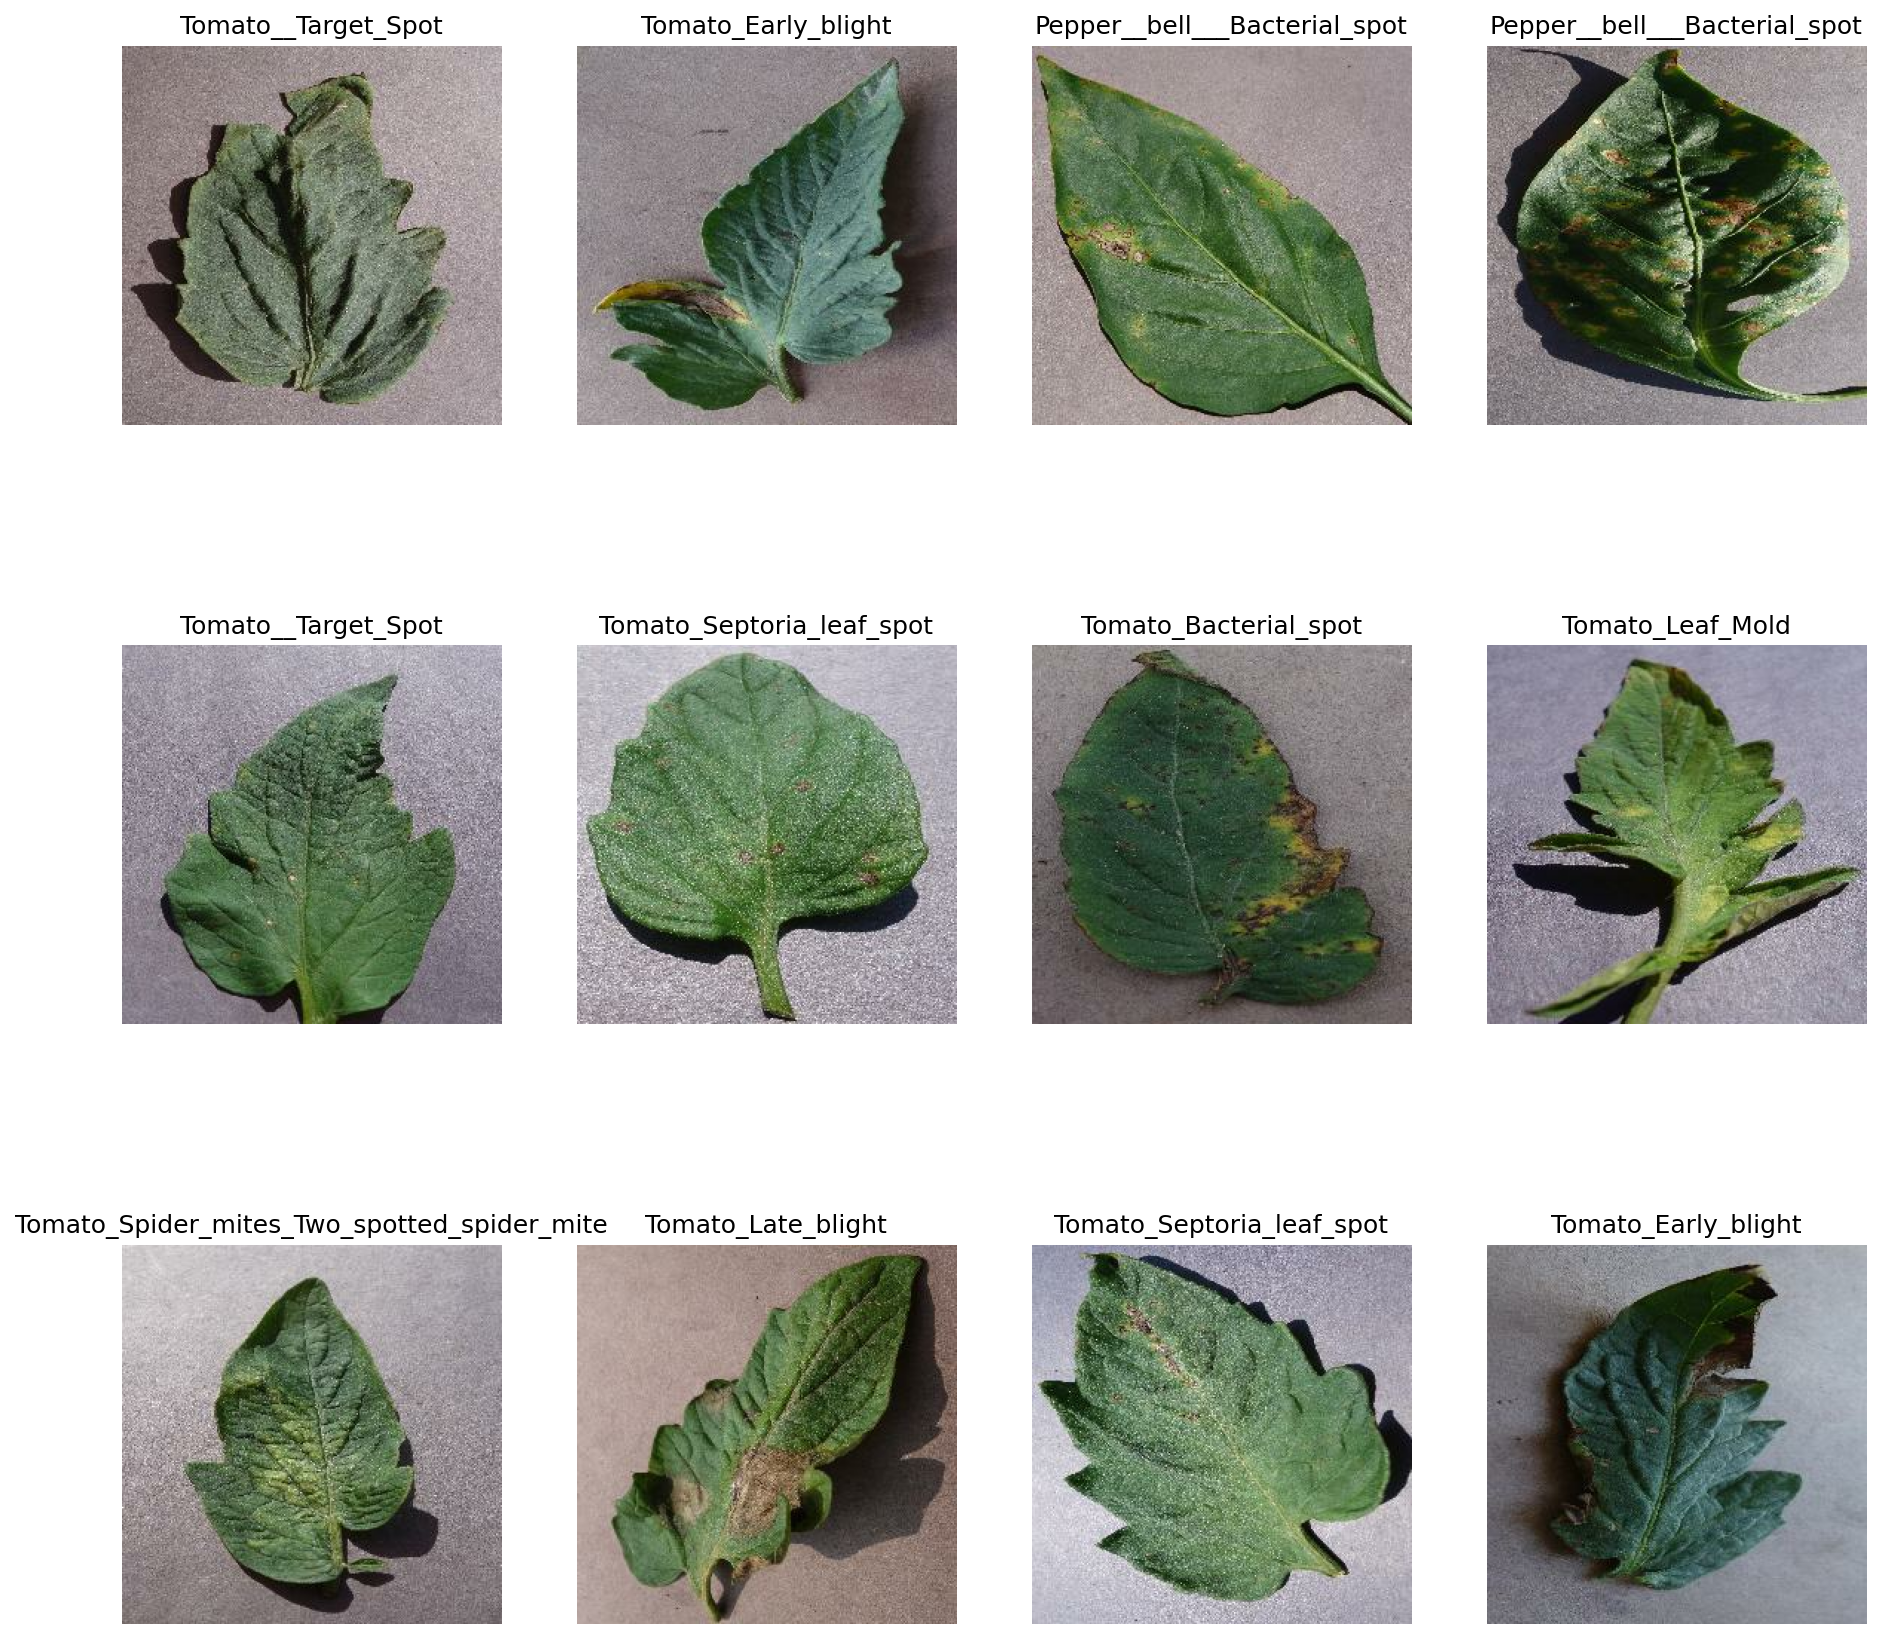

In [30]:
plt.figure(figsize=(15, 15), dpi=150)
for image_batch, label_batch in dataset.take(VIZ_BATCH_INDEX):
    for i in range(VIZ_SAMPLES_COUNT):
        ax = plt.subplot(3, int(VIZ_SAMPLES_COUNT/3), i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [46]:
train_config = {
    "epochs": 50,
    "train_split": 0.8,
    "test_split": 0.1,
    "shuffle": True
}

In [47]:
def split_dataset(dataset, train_split, test_split, shuffle=False, shuffle_size=10000):
    ds_len = len(dataset)
    
    if shuffle:
        ds = dataset.shuffle(shuffle_size, seed=10)
    
    train_size = int(ds_len * train_split)
    test_size = int(ds_len * test_split)

    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size).take(test_size)
    val_ds = ds.skip(train_size).skip(test_size)
    
    return train_ds, test_ds, val_ds

In [48]:
train_ds, test_ds, val_ds = split_dataset(
    dataset, 
    train_config["train_split"],
    train_config["test_split"], 
    shuffle=train_config["shuffle"]
)

print(f"...Train set: {len(train_ds)}")
print(f"...Val set: {len(val_ds)}")
print(f"...Test set: {len(test_ds)}")

...Train set: 516
...Val set: 65
...Test set: 64


In [49]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [51]:
Resize_rescale = Keras.Sequential([
    Keras.layers.Resizing(config["image_size"], config["image_size"]),
    Keras.layers.Rescaling(scale=1./255)
])

In [52]:
Augmentation = Keras.Sequential([
    Keras.layers.RandomFlip(),
    Keras.layers.RandomRotation(factor=0.2),
    Keras.layers.RandomContrast(0.05),
    Keras.layers.RandomBrightness(0.05)
])